# Detecting Kermit and Waldorf & Statler based on audio features

This notebook documents our approach to detect Kermit and Waldorf and Statler based on audio feature-engineering.  
We employ a Logistic Regression Classifier to predict the characters based on different audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**
| Date | Task | Hours |
| --- | --- | --- |
| 27.11.2023 | Setup notebook, first experiments | 3 |
| 27.11.2023 | Implement "utils/MuppetDataset.py" that generally loads and handles the annotated video data | 1 |
| 28.11.2023 | Experiment & build feature extraction for both characters, align audio samples with frame annotations, format the dataset for the classifier | 3 |
| 29.11.2023 | Add KNN classifier. Try other audio features due to poor performance for Waldorf & Statler, experiment with different splits | 2.5 |
| 29.11.2023 | Add (visual) evaluation tools that generalize for all Sim1/2 tasks (cf. utils folder) | 1|


## Imports


In [316]:
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


## Loading the data

Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously.


In [285]:
extract_audio = False
extract_frames = True


In [286]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)


Example for handling the data for video 0:

```python
dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]
```


## Audio feature extraction


### Aligning audio features with video frame rate

The annotations are at the video frame level, for audio too. Therefore, we need to align the audio features with the video frames.

We start by checking the framerate of the videos and remind of our audio sampling rate:


In [287]:
%%sh
ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 ../data/Muppets-02-01-01.avi


25/1


In [288]:
FRAMES_PER_SECOND = 25


In [289]:
AUDIO_SAMPLING_RATE = dataset.audios[0]["sr"]
AUDIO_SAMPLING_RATE


44100

There are 25 frames per second, and the 16k audio samples per second.  
We therefore have $\frac{44100}{25} = 1764$ audio samples per frame and divide our audio features in windows of 1764 samples.


### Features for Kermit

We make our decisions based on the observation that Kermit displays a distinct audio pattern where his interventions start with screaming, and transition to mumbling as he speaks, which should correspond to a high foundational frequency.  
We therefore decide to extract the fundational frequency of the audio (pitch), as well as loudness.

**We normalize all extracted features.**


In [290]:
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    # Loudness (through RMS energy)
    audio["loudness_rms"] = librosa.util.normalize(
        librosa.feature.rms(
            y=audio["audio"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            frame_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Zero crossing rate
    audio["zcr"] = librosa.util.normalize(
        librosa.feature.zero_crossing_rate(
            y=audio["audio"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            frame_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )


This approach with the `hop_length` of 1764 samples leads to feature vectors of the length of the number of frames, which is what we desired.


### Features for Waldorf & Statler

As for Waldorf & Statler, we observe they have low, cranky voices with a very specific overtone structure.  
We therefore decide to extract spectral and timber features.


In [291]:
for audio in dataset.audios:
    # Spectral contrast measures the difference in amplitude between peaks and valleys in the spectrum, which can capture aspects of timbre
    audio["spectral_contrast"] = librosa.util.normalize(
        librosa.feature.spectral_contrast(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_bands=5,
        )
    )  # spectral contrast values across n_bands different frequency bands for each frame, +1 that is "overall"
    # Spectral roll-off provides insights into the shape of the spectral energy distribution, affecting the timbre
    audio["spectral_rolloff"] = librosa.util.normalize(
        librosa.feature.spectral_rolloff(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Chroma features
    audio["chroma"] = librosa.util.normalize(
        librosa.feature.chroma_stft(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )
    # MFCCs
    audio["mfcc"] = librosa.util.normalize(
        librosa.feature.mfcc(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_mfcc=13,
        )
    )
    # TODO: try spectral centroid


In [292]:
dataset.audios[0]["mfcc"].shape


(13, 38681)

In [293]:
for i in range(3):
    assert (
        dataset.audios[i]["spectral_rolloff"].shape[0]
        == dataset.annotations.loc[dataset.annotations.Video == i].Frame_number.max()
        + 1
    )


### Merge into the dataframe that will be used for model training & prepare the model dataset

We merge all information into a dataframe with columns `[video_idx, frame_idx, loudness_rms, zcr, spectral_contrast_columns*5, spectral_rolloff, kermit_present, waldorf_statler_present]`.


In [294]:
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    "loudness_rms": audio["loudness_rms"],
                    "zcr": audio["zcr"],
                    # "spectral_contrast_1": audio["spectral_contrast"][0],
                    # "spectral_contrast_2": audio["spectral_contrast"][1],
                    # "spectral_contrast_3": audio["spectral_contrast"][2],
                    # "spectral_contrast_4": audio["spectral_contrast"][3],
                    # "spectral_contrast_5": audio["spectral_contrast"][4],
                    # "spectral_contrast_6": audio["spectral_contrast"][5],
                    # "chroma1": audio["chroma"][0],
                    # "chroma2": audio["chroma"][1],
                    # "chroma3": audio["chroma"][2],
                    # "chroma4": audio["chroma"][3],
                    # "chroma5": audio["chroma"][4],
                    # "chroma6": audio["chroma"][5],
                    "mfcc1": audio["mfcc"][0],
                    "mfcc2": audio["mfcc"][1],
                    "mfcc3": audio["mfcc"][2],
                    "mfcc4": audio["mfcc"][3],
                    "mfcc5": audio["mfcc"][4],
                    "mfcc6": audio["mfcc"][5],
                    "mfcc7": audio["mfcc"][6],
                    "mfcc8": audio["mfcc"][7],
                    "mfcc9": audio["mfcc"][8],
                    "mfcc10": audio["mfcc"][9],
                    "mfcc11": audio["mfcc"][10],
                    "mfcc12": audio["mfcc"][11],
                    "mfcc13": audio["mfcc"][12],
                    # "spectral_rolloff": audio["spectral_rolloff"],
                }
            ),
        ],
        ignore_index=True,
    )
# Add annotations
audio_features = audio_features.merge(
    dataset.annotations[["Video", "Frame_number", "Kermit", "Audio_StatlerWaldorf"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])


Sanity check:


In [295]:
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Kermit"].sum() == audio_features["Kermit"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Kermit"].values, audio_features["Kermit"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_StatlerWaldorf"].values,
    audio_features["Audio_StatlerWaldorf"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)


In [296]:
audio_features.sample(10)


,video_idx,frame_idx,loudness_rms,zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,Kermit,Audio_StatlerWaldorf
111991,2,34604,0.616463,0.190728,-1.0,0.638843,-0.369514,0.134049,-0.118923,-0.017910,-0.014788,-0.124241,-0.009876,-0.137308,-0.036410,0.012613,-0.085932,1,0
5664,0,5664,0.347750,0.021921,-1.0,0.524993,-0.011842,0.059703,0.025318,0.052518,0.032028,-0.005845,0.032592,0.019944,0.024838,-0.002039,-0.016334,0,0
4455,0,4455,0.276985,0.034447,-1.0,0.529903,-0.020544,0.032598,0.102787,0.039806,0.024079,0.013306,0.019538,0.023362,0.010433,0.020251,0.033982,0,0
41362,1,2681,0.248619,0.089522,-1.0,0.587195,-0.210180,0.001013,-0.025838,0.039573,-0.004027,-0.092989,-0.049260,-0.065745,-0.010239,-0.014877,-0.014470,1,0
98277,2,20890,0.017750,0.184106,-1.0,0.271441,-0.053772,0.001168,-0.009910,-0.008469,0.034177,-0.001991,-0.026495,-0.014133,0.006868,0.001837,-0.004567,0,0
107771,2,30384,0.068205,0.164238,-1.0,0.436444,-0.135313,0.078907,-0.051838,-0.018157,0.017752,-0.028136,0.025243,-0.013529,0.005664,0.010903,-0.008302,1,0
8080,0,8080,0.217124,0.085595,-1.0,0.583227,-0.136335,0.078865,-0.016093,-0.011287,-0.009261,-0.062128,-0.020456,-0.009796,0.030976,0.022600,0.012838,0,0
114723,2,37336,0.379305,0.255629,-1.0,0.874518,-0.576530,0.199248,-0.248031,0.080930,-0.024018,-0.037058,0.008681,-0.086273,0.013212,-0.055173,0.036657,1,0
108316,2,30929,0.271979,0.030464,-1.0,0.292202,-0.063911,0.156776,0.013516,-0.018684,-0.046638,-0.067016,-0.017337,-0.002308,-0.007694,-0.058893,-0.004383,1,0
56773,1,18092,0.182891,0.054934,-1.0,0.576800,-0.069847,-0.008383,0.009777,-0.033008,-0.028837,-0.036411,0.012280,0.019039,-0.008018,-0.028906,-0.045315,0,0


In [297]:
audio_features.describe()
# TODO: We observe that the last band of spectral contrast, and spectral rolloff, are almost always 1. We might change those features.


,video_idx,frame_idx,loudness_rms,zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,Kermit,Audio_StatlerWaldorf
count,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000
mean,0.998421,19313.777952,0.277597,0.142501,-0.999845,0.515892,-0.198498,0.082622,-0.055819,0.020853,-0.028263,-0.037581,-0.010294,-0.035551,-0.009281,-0.011054,-0.010243,0.286569,0.023446
std,0.816088,11151.279978,0.175298,0.097122,0.003453,0.196680,0.157292,0.093794,0.093546,0.064005,0.048802,0.050639,0.038997,0.041687,0.034982,0.033086,0.031954,0.452160,0.151315
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.171666,-0.837417,-0.261846,-0.584988,-0.244149,-0.452329,-0.305070,-0.311839,-0.294416,-0.342918,-0.211301,-0.199215,0.000000,0.000000
25%,0.000000,9657.000000,0.132622,0.085595,-1.000000,0.382151,-0.301866,0.018566,-0.114739,-0.021103,-0.056437,-0.069311,-0.034644,-0.061634,-0.030407,-0.031132,-0.030002,0.000000,0.000000
50%,1.000000,19314.000000,0.262112,0.123173,-1.000000,0.515883,-0.184795,0.067908,-0.043981,0.013232,-0.022295,-0.035913,-0.010772,-0.032805,-0.008476,-0.009237,-0.010033,0.000000,0.000000
75%,2.000000,28971.000000,0.404137,0.168212,-1.000000,0.655724,-0.080510,0.135623,0.009552,0.056118,0.004748,-0.005087,0.013125,-0.007206,0.012100,0.009801,0.009176,1.000000,0.000000
max,2.000000,38705.000000,1.000000,1.000000,-0.659745,1.000000,0.218235,0.667775,0.264881,0.416020,0.172590,0.318462,0.174686,0.290624,0.252358,0.194851,0.188683,1.000000,1.000000


We extract the `X` and `y` matrices for the model:


In [298]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = audio_features.drop(
    columns=["Kermit", "Audio_StatlerWaldorf", "video_idx", "frame_idx"]
)
y = audio_features[["Kermit", "Audio_StatlerWaldorf"]]


And then split into train and test sets by a 80/20 ratio.
However, we do **not** use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [299]:
# X_train = X.head(int(X.shape[0] * 0.8))
# X_test = X.tail(int(X.shape[0] * 0.2))
# y_train = y.head(int(y.shape[0] * 0.8))
# y_test = y.tail(int(y.shape[0] * 0.2))

# assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
# assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


In [300]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Training the audio-based model


For this task, we decide to use a k-nearest-neighbors classifier.
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither Kermit nor Waldorf & Statler are present
- 1: Kermit is present
- 2: Waldorf & Statler are present
- 3: both are present

**Important remark**: we notice that Kermit is the only character where, in the ground truth, the presence is annotated through a single column that does not distinguish between audio and vision. Therefore, we expected the performance of this audio-based model to be worse for Kermit based on evaluation metrics.


In [301]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


def convert_predictions_to_one_hot(predictions):
    y_pred_one_hot = np.zeros((predictions.size, y_train.shape[1]))
    y_pred_one_hot[
        np.arange(predictions.size), predictions - np.any(y_train, axis=1)
    ] = 1


**Training the kNN classifier:**


In [302]:
knn = KNeighborsClassifier(n_neighbors=2)  # TODO: tune n_neighbors
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


## Evaluating the audio-based model


In [303]:
# Convert labels for the first character
y_test_kermit = (y_test == 1) | (y_test == 3)
y_pred_kermit = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_wald_stat = (y_test == 2) | (y_test == 3)
y_pred_wald_stat = (y_pred == 2) | (y_pred == 3)


In [304]:
# Compute metrics for the first character
accuracy_kermit = accuracy_score(y_test_kermit, y_pred_kermit)
precision_kermit = precision_score(y_test_kermit, y_pred_kermit)
recall_kermit = recall_score(y_test_kermit, y_pred_kermit)
f1_kermit = f1_score(y_test_kermit, y_pred_kermit)
map_kermit = average_precision_score(y_test_kermit, y_pred_kermit)

# Compute metrics for the second character
accuracy_wald_stat = accuracy_score(y_test_wald_stat, y_pred_wald_stat)
precision_wald_stat = precision_score(y_test_wald_stat, y_pred_wald_stat)
recall_wald_stat = recall_score(y_test_wald_stat, y_pred_wald_stat)
f1_wald_stat = f1_score(y_test_wald_stat, y_pred_wald_stat)
map_wald_stat = average_precision_score(y_test_wald_stat, y_pred_wald_stat)

# Compute metrics for the general classifier as a whole
# TODO: based on results change feature eng, training, tuning, splitting... classifier?
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


***Kermit***
	Accuracy: 0.7678733226905985
	Precision: 0.6727584237578527
	Recall: 0.3575113808801214
	F1: 0.4669044787950852
	MAP: 0.4231998993455499
***Waldorf & Statler***
	Accuracy: 0.9777365491651205
	Precision: 0.5333333333333333
	Recall: 0.09195402298850575
	F1: 0.1568627450980392
	MAP: 0.06949345508172408
***General model metrics***
	Accuracy: 0.7496656167752513
	Precision: 0.7331470593141176
	Recall: 0.7496656167752513
	F1: 0.7184527912869053


ZCR, rms & mfccs + random split:

```
***Kermit***
	Accuracy: 0.7678733226905985
	Precision: 0.6727584237578527
	Recall: 0.3575113808801214
	F1: 0.4669044787950852
	MAP: 0.4231998993455499
***Waldorf & Statler***
	Accuracy: 0.9777365491651205
	Precision: 0.5333333333333333
	Recall: 0.09195402298850575
	F1: 0.1568627450980392
	MAP: 0.06949345508172408
***General model metrics***
	Accuracy: 0.7496656167752513
	Precision: 0.7331470593141176
	Recall: 0.7496656167752513
	F1: 0.7184527912869053
```


***Kermit***
	Accuracy: 0.7678733226905985
	Precision: 0.6727584237578527
	Recall: 0.3575113808801214
	F1: 0.4669044787950852
	MAP: 0.4231998993455499
***Waldorf & Statler***
	Accuracy: 0.9777365491651205
	Precision: 0.5333333333333333
	Recall: 0.09195402298850575
	F1: 0.1568627450980392
	MAP: 0.06949345508172408
***General model metrics***
	Accuracy: 0.7496656167752513
	Precision: 0.7331470593141176
	Recall: 0.7496656167752513
	F1: 0.7184527912869053


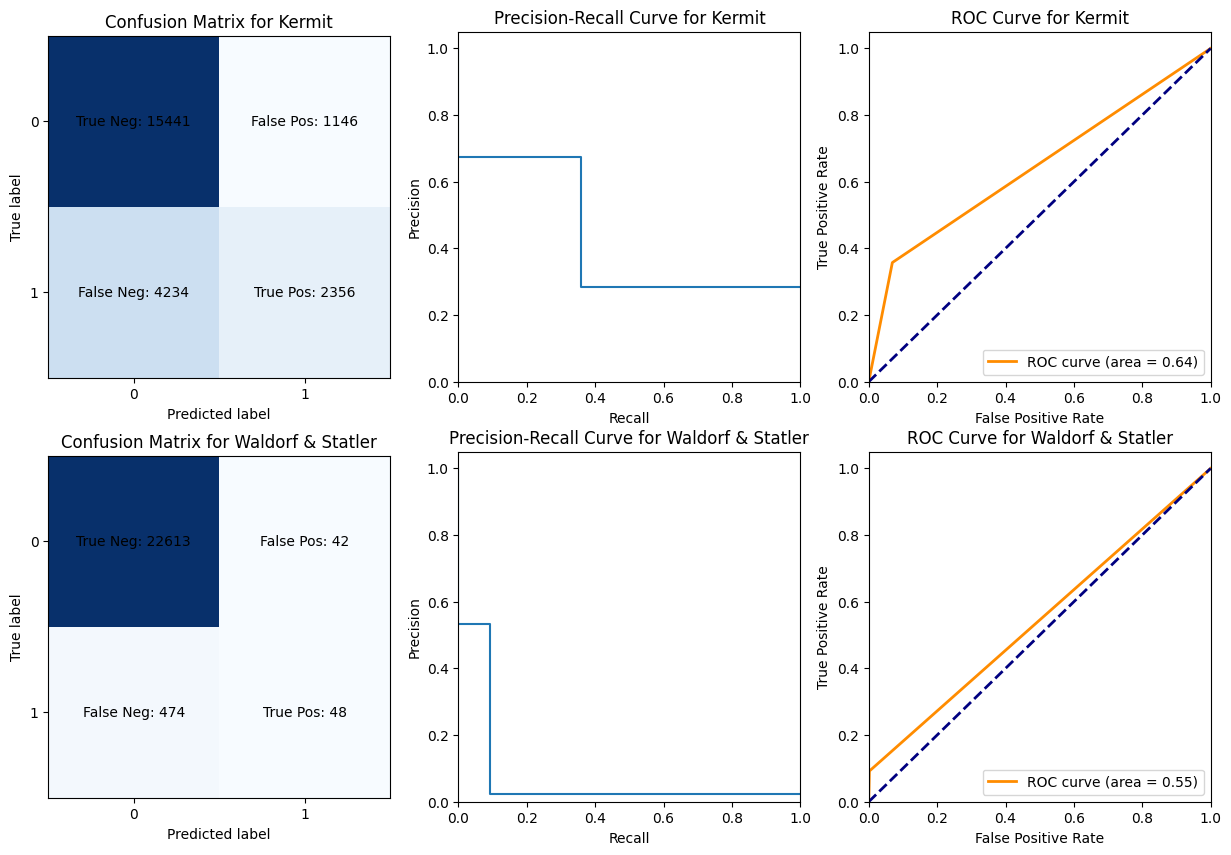

In [318]:
# *** Metrics ***
print(
    f"***Kermit***\n\tAccuracy: {accuracy_kermit}\n\tPrecision: {precision_kermit}\n\tRecall: {recall_kermit}\n\tF1: {f1_kermit}\n\tMAP: {map_kermit}"
)
print(
    f"***Waldorf & Statler***\n\tAccuracy: {accuracy_wald_stat}\n\tPrecision: {precision_wald_stat}\n\tRecall: {recall_wald_stat}\n\tF1: {f1_wald_stat}\n\tMAP: {map_wald_stat}"
)
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Kermit
plot_confusion_matrix(
    y_test_kermit, y_pred_kermit, "Confusion Matrix for Kermit", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_kermit, y_pred_kermit, "Precision-Recall Curve for Kermit", ax=axs[0, 1]
)
plot_roc_curve(y_test_kermit, y_pred_kermit, "ROC Curve for Kermit", ax=axs[0, 2])
# Waldorf & Statler
plot_confusion_matrix(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Confusion Matrix for Waldorf & Statler",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Precision-Recall Curve for Waldorf & Statler",
    ax=axs[1, 1],
)
plot_roc_curve(
    y_test_wald_stat, y_pred_wald_stat, "ROC Curve for Waldorf & Statler", ax=axs[1, 2]
)
